## Single axis and small fit domain test

In [2]:
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
# import electrode
from electrode import (System, PolygonPixelElectrode, euler_matrix,
    PointPixelElectrode, PotentialObjective,
    PatternRangeConstraint, shaped, utils)
from scipy.signal import argrelextrema
import math
from scipy.optimize import minimize

In [3]:
# n electrodes per row (10 default)
# number of rows (2 default)
# width of electrode
# height of electrode
# spacing between electrodes
# tuple of coordinates to start each row
    # top row x-coordinate (bottom left point)
    # top row y-coordinate (bottom left point)

#...
# bottom row x-coordinate (bottom left point)
# bottom row y-coordinate (bottom left point)
def trap(spacing,
        gnd_width, gnd_height, gnd_start_pos,
        dc_width, dc_height, dc_start_pos,
        rf_width, rf_height, rf_start_pos,
        dc_mid_width, dc_mid_height, dc_mid_start_pos,
        n=9, r=2):

    electrodes = []

    #add dc electrodes
    #define effective size, without dielectric gaps
    w_eff = dc_width + spacing
    h_eff = dc_height + spacing
    #start with top row
    row = 0
    for sp in dc_start_pos:
        xp_start = sp[0] - spacing/2
        yp = sp[1] - spacing/2
        for electrode in range(n):
            # e.g. electrode 2 would be leftmost in top row
            # e.g. electrode 12 would be leftmost in bottom row
            electrode_id = str(row * (n+1) + electrode + 2)
            x_shift = electrode * w_eff
            xp = xp_start + x_shift
            # print(xp)
            electrodes.append(
                (electrode_id, [[
                    (xp, yp),
                    (xp + w_eff, yp),
                    (xp + w_eff, yp + h_eff),
                    (xp, yp + h_eff)
                ]])
            )
        row += 1
    dc_mid_w_eff = dc_mid_width + spacing
    dc_mid_h_eff = dc_mid_height + spacing
    for i in range (2):
        xp = dc_mid_start_pos[i][0] - spacing/2
        yp = dc_mid_start_pos[i][1] - spacing/2
        dc_mid_id = str(10*i + 1)
        electrodes.append(
            (dc_mid_id, [[
                (xp, yp),
                (xp + dc_mid_w_eff, yp),
                (xp + dc_mid_w_eff, yp + dc_mid_h_eff),
                (xp, yp + dc_mid_h_eff)
            ]])
        )
    
    # add rf electrodes
    rf_w_eff = rf_width + spacing
    rf_h_eff = rf_height + spacing
    rf_electrodes = []
    for i in range (2):
        xp = rf_start_pos[i][0] - spacing/2
        yp = rf_start_pos[i][1] - spacing/2
        # rf_e_id = str('r'+i+1) #use this for unique rf electrode id
        rf_electrodes.append([
            (xp, yp),
            (xp + rf_w_eff, yp),
            (xp + rf_w_eff, yp + rf_h_eff),
            (xp, yp + rf_h_eff)
        ])
        rf_e_id = str('r')
    electrodes.append(
        (rf_e_id, rf_electrodes)
    )
    
    # add gnd electrodes
    #define effective size, without dielectric gaps
    gnd_w_eff = gnd_width + spacing
    gnd_h_eff = gnd_height + spacing
    gnd_electrodes = []
    for sp in gnd_start_pos:
        xp = sp[0] - spacing/2
        yp = sp[1] - spacing/2
        for gnd in range(n):
            gnd_id = 'gnd'
            gnd_electrodes.append([
                (xp, yp),
                (xp + gnd_w_eff, yp),
                (xp + gnd_w_eff, yp + gnd_h_eff),
                (xp, yp + gnd_h_eff)
            ])
    electrodes.append(
        (gnd_id, gnd_electrodes)
    )
    
    s = System([PolygonPixelElectrode(name=n, paths=map(np.array, p))
                for n, p in electrodes])
    # apply rf potential to electrode
    # s['r'].rf = 1.
    return s

[[-500.   602.5]]


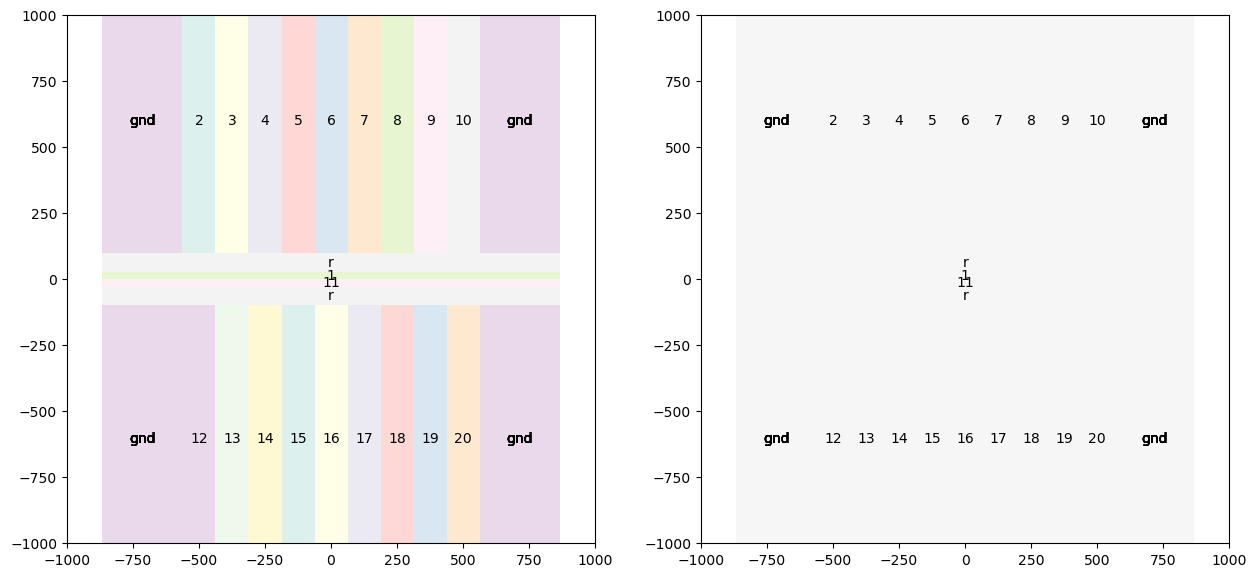

In [5]:
spacing = 5.
n = 9
dc_width = 120.
# dc_height = 1000.
gnd_width = 300.
gnd_height = 1000.
dc_height = 1000.
dc_mid_height = 20.
# dc_mid_width = n * dc_width + (n-1) * spacing
dc_mid_width = n * dc_width + (n+1) * spacing + 2 * gnd_width
rf_height = 70.
# rf_width = n * dc_width + (n-1) * spacing
rf_width = n * dc_width + (n+1) * spacing + 2 * gnd_width

leftmost_electrode_x = -(4.5*dc_width + 4*spacing)
rightmost_electrode_x = (4.5*dc_width + 4*spacing)

gnd_start_pos = [(leftmost_electrode_x-gnd_width-spacing, (2.5*spacing + dc_mid_height + rf_height)),
                (leftmost_electrode_x-gnd_width-spacing, -(2.5*spacing + dc_mid_height + rf_height + dc_height)),
                (rightmost_electrode_x+spacing, (2.5*spacing + dc_mid_height + rf_height)),
                (rightmost_electrode_x+spacing, -(2.5*spacing + dc_mid_height + rf_height + dc_height))
                ]

dc_start_pos = [(leftmost_electrode_x, (2.5*spacing + dc_mid_height + rf_height)),
                (leftmost_electrode_x, -(2.5*spacing + dc_mid_height + rf_height + dc_height))]
rf_start_pos = [(leftmost_electrode_x-gnd_width-spacing, (1.5*spacing + dc_mid_height)),
                (leftmost_electrode_x-gnd_width-spacing, -(1.5*spacing + dc_mid_height + rf_height))]
dc_mid_start_pos = [(leftmost_electrode_x-gnd_width-spacing, (.5*spacing)),
                (leftmost_electrode_x-gnd_width-spacing, -(.5*spacing +dc_mid_height))]

s = trap(spacing,
        gnd_width, gnd_height, gnd_start_pos,
        dc_width, dc_height, dc_start_pos,
        rf_width, rf_height, rf_start_pos,
        dc_mid_width, dc_mid_height, dc_mid_start_pos,
        n, r=2)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
print(s["2"].to_points().points) # use this to get the centroid coordinates of an electrode
s.plot(ax[0])
# s.plot_voltages(ax[1], u=s.rfs)
# s['2'].dc = 1.
s.plot_voltages(ax[1])

r= 1000
for axi in ax.flat:
    axi.set_aspect("equal")
    axi.set_xlim(-r, r)
    axi.set_ylim(-r, r)

In [6]:
l = 1e-6 # µm length scale
u = 20. # V rf peak voltage
m = 40*ct.atomic_mass # 40Ca+ ion mass
q = 1*ct.elementary_charge # ion charge

f = 30e6
o = 2*np.pi*f # rf frequency in rad/s
s["r"].rf = u*np.sqrt(q/m)/(2*l*o)

# searches for potential minimum point given the starting point
x0 = s.minimum((0, 0, 1.), axis=(1, 2))
# using lengthscale 1e-6 m gives the right height for minimum at 50µm
# x0 = np.array([0.0, 0.0, 50.0])
# print(x0)

for line in s.analyze_static(x0, axis=(1, 2), m=m, q=q, l=l, o=o):
    print(line)

parameters:
 f=30 MHz, m=40 amu, q=1 qe, l=1 µm, scale=4.12 V'/V_SI
corrdinates:
 analyze point: [0.00000000e+00 4.34002626e-15 4.97375282e+01]
               ([0.00000000e+00 4.34002626e-15 4.97375282e+01] µm)
 minimum is at offset: [0. 0. 0.]
                      ([0. 0. 0.] µm)
potential:
 dc electrical: 0 eV
 rf pseudo: 6.5e-09 eV
 saddle offset: [-1.74598588e-01  4.01329185e-08  7.90990106e-03]
               ([-1.74598588e-01  4.01329185e-08  7.90990106e-03] µm)
 saddle height: -6.5e-09 eV
force:
 dc electrical: [0. 0. 0.] eV/l
               ([0. 0. 0.] eV/m)
 rf pseudo: [ 0.00000000e+00  1.13588964e-18 -1.65526020e-06] eV/l
           ([ 0.00000000e+00  1.13588964e-12 -1.65526020e+00] eV/m)
modes:
 pp+dc normal curvatures: [-1.18909507e-12  2.09255087e-04  2.09411976e-04]
 motion is bounded: True
 pseudopotential modes:
  a: nan MHz, [1. 0. 0.]
  b: 3.576 MHz, [-0.00000000e+00 -1.00000000e+00 -4.33757064e-13]
  c: 3.577 MHz, [ 0.00000000e+00 -4.33757064e-13  1.00000000e+00]
  

/opt/homebrew/anaconda3/envs/pqe7/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-macosx-10.9-x86_64.egg/electrode/system.py:879: RuntimeWarning: invalid value encountered in sqrt
  freqs_pp = np.sqrt(q*curves/m)/(2*np.pi*l)


In [7]:
def single_axis(axis, bounds, res, shift={'z': 50}):
    ts = np.linspace(bounds[0], bounds[1], res)
    zeros = np.zeros(res)
    line = []
    if (axis == 'x'):
        line = np.column_stack([ts.T, zeros, zeros])
    if (axis == 'y'):
        line = np.column_stack([zeros, ts.T, zeros])
    if (axis == 'z'):
        line = np.column_stack([zeros, zeros, ts.T])

    # to shift line height
    for key, val in shift.items():
        if (key == 'x'):
            line += np.column_stack([np.ones(res) * val, zeros, zeros])
        if (key == 'y'):
            line += np.column_stack([zeros, np.ones(res) * val, zeros])
        if (key == 'z'):
            line += np.column_stack([zeros, zeros, np.ones(res) * val])
    return line

def make_xy_grid_flat(x_grid_bounds, y_grid_bounds, z, grid_res):
    ts_x = np.linspace(x_grid_bounds[0], x_grid_bounds[1], grid_res[0])
    ts_y = np.linspace(y_grid_bounds[0], y_grid_bounds[1], grid_res[1])
    grid = []
    for y in ts_y:
        for x in ts_x:
            grid.append([x, y, z])
    return grid, ts_x, ts_y

def make_xyz_grid_flat(x_grid_bounds, y_grid_bounds, z_grid_bounds, grid_res):
    ts_x = np.linspace(x_grid_bounds[0], x_grid_bounds[1], grid_res[0])
    ts_y = np.linspace(y_grid_bounds[0], y_grid_bounds[1], grid_res[1])
    ts_z = np.linspace(z_grid_bounds[0], z_grid_bounds[1], grid_res[2])
    grid = []
    for z in ts_z:
        for y in ts_y:
            for x in ts_x:
                grid.append([x, y, z])
    return grid, ts_x, ts_y, ts_z

In [31]:
# define fit params
length = 20. #µm
res = 10001

# create fit axes
x = single_axis('x', (-length/2,length/2), res)
y = single_axis('y', (-length/2,length/2), res)
z_length = 5
z = single_axis('z', (-z_length/2,z_length/2), res)

# find individual potential contributions
p_x = s.individual_potential(x, 0)
p_y = s.individual_potential(y, 0)
p_z = s.individual_potential(z, 0)

In [32]:
# solve for 1 electrode along 1 axis
def solve_axes_coeffs(axis, p, order=0):
    #want to solve equation f = c + a_x1 * x + a_x2 * x^2
    # create matrix of coordinate values
    c = np.ones(axis.shape[0])
    A = np.column_stack([c, axis])
    for i in range(2, order+1):
        A = np.column_stack([A, axis**i])
    c_arr = []
    c, residuals, rank, s = np.linalg.lstsq(A, p, rcond=None)
    # print(residuals)
    c_arr.append(c)
    # print(f'electrode {el_i}:', c)
    return c_arr, A, residuals[0]

# c_arr = solve_axes_coeffs(p_x, x[:,0], order=2)

Plot voltages along each axis

In [33]:
import pandas as pd
from datetime import datetime

/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_10799/3708504551.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, num_axes, figsize=(fig_width, 1/2*fig_width))


['id', 'c_x0', 'c_x1', 'c_x2', 'c_y0', 'c_y1', 'c_y2', 'c_z0', 'c_z1', 'c_z2', 'residuals_x', 'residuals_y', 'residuals_z']


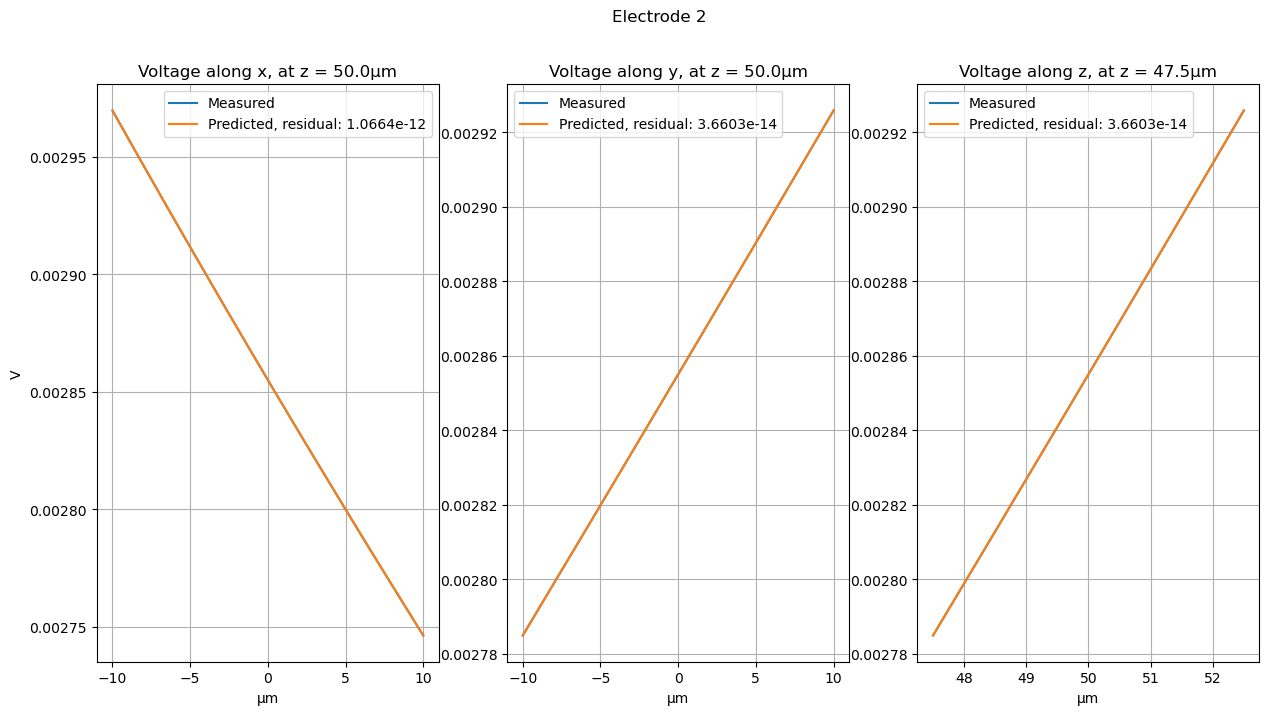

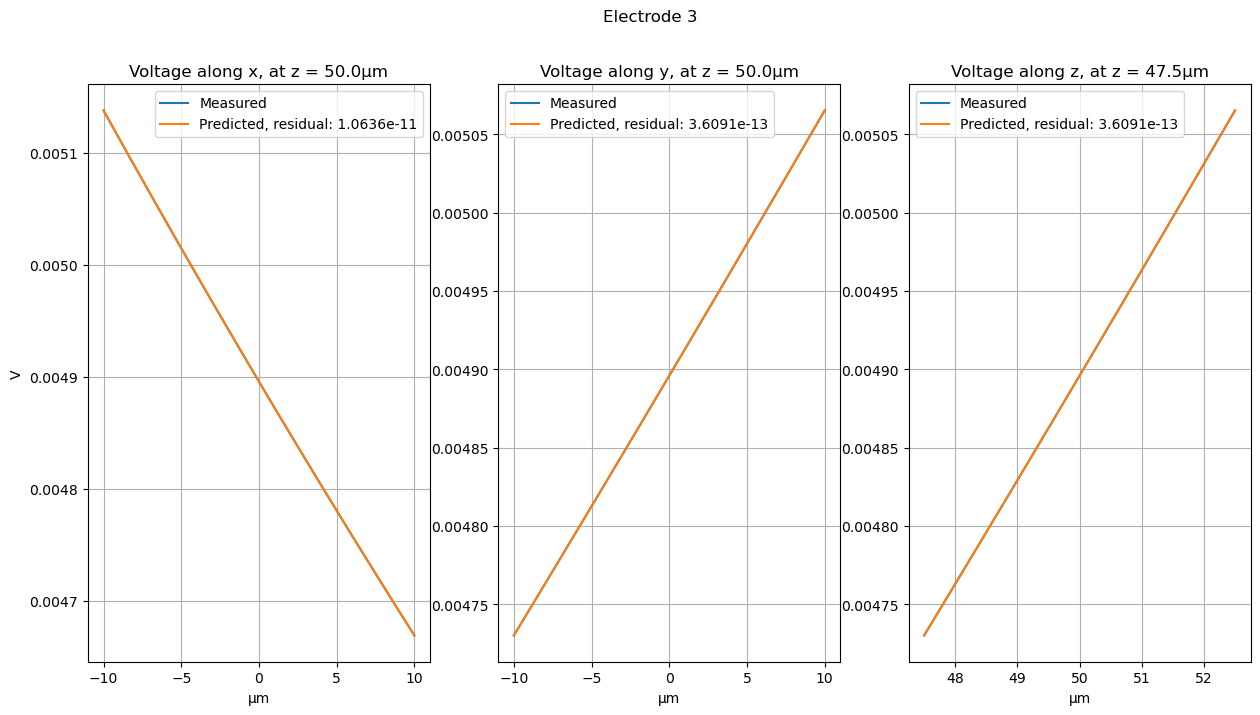

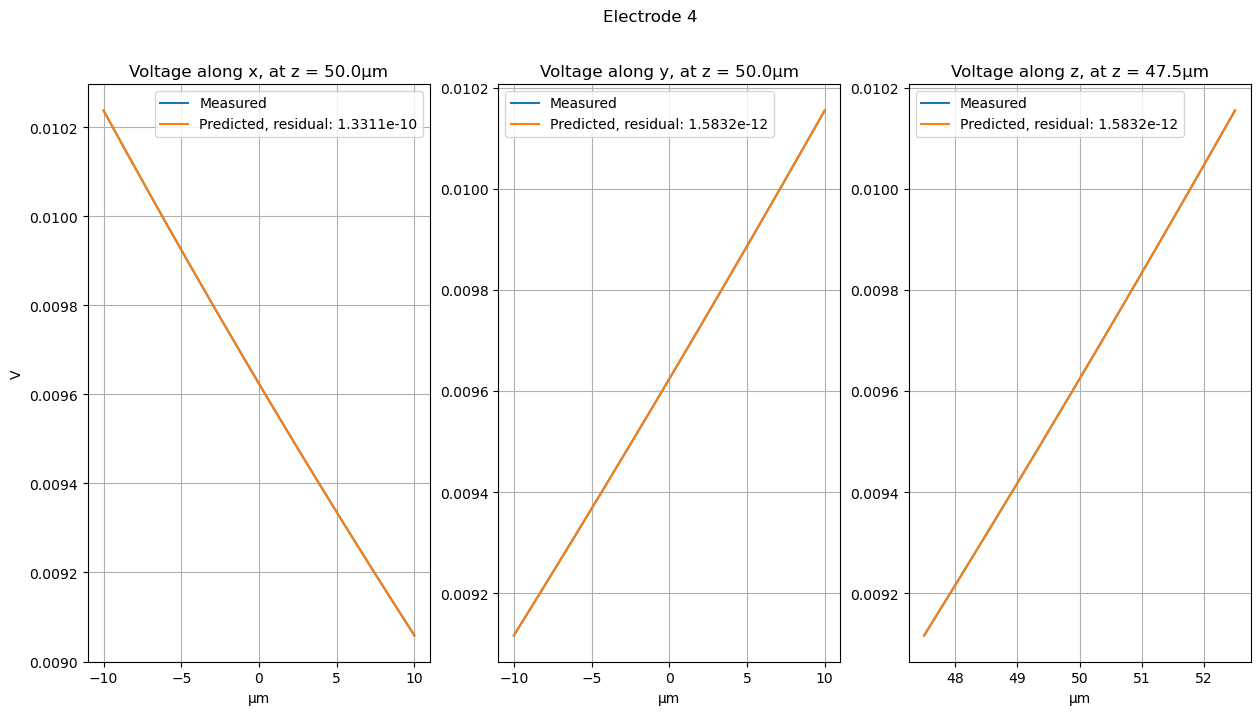

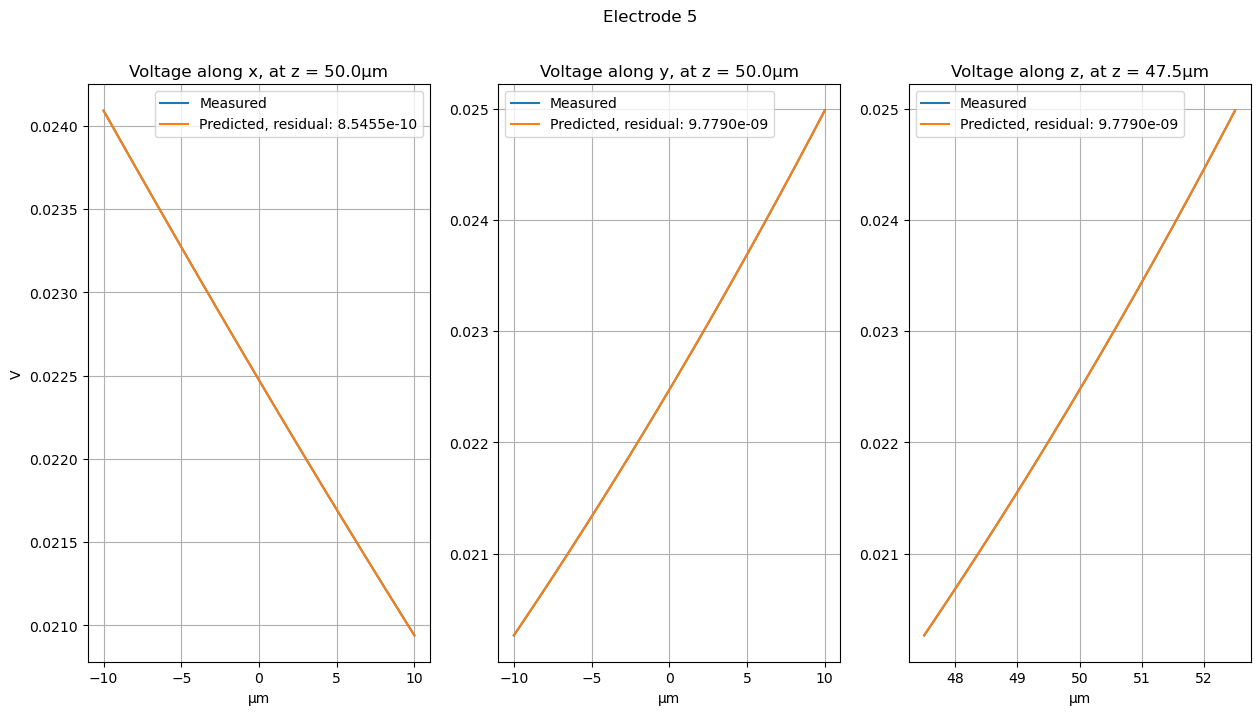

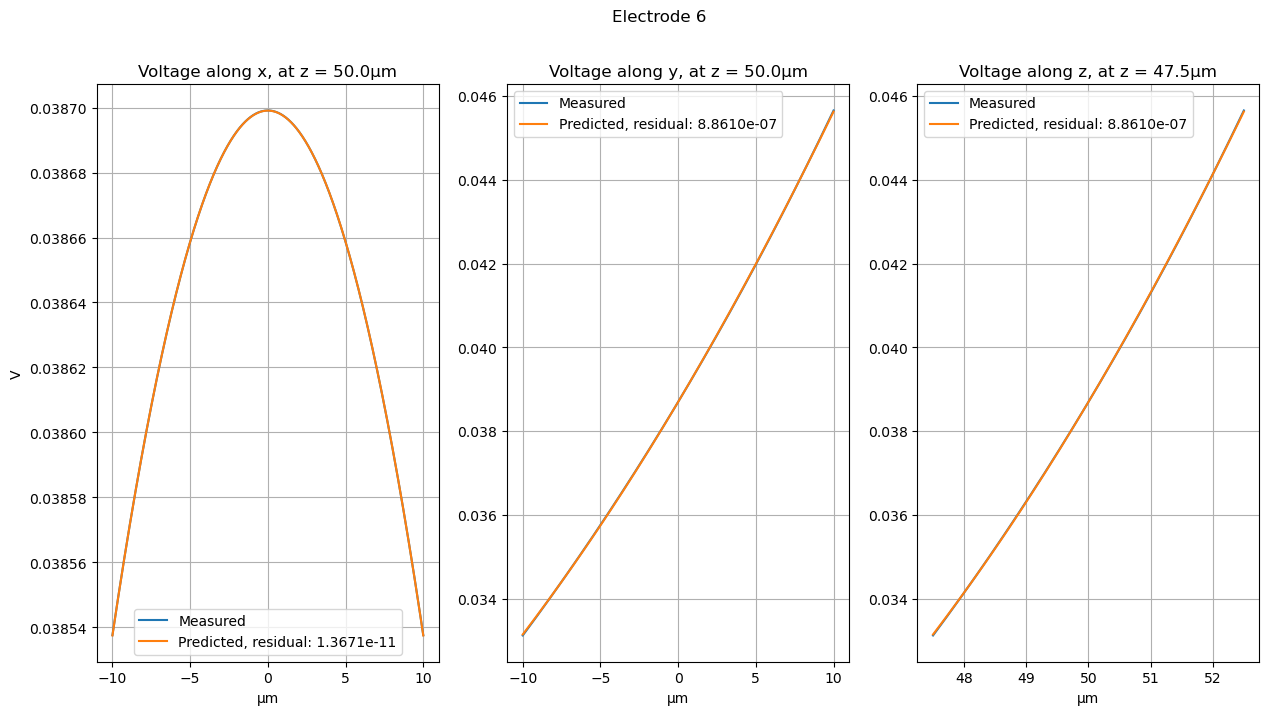

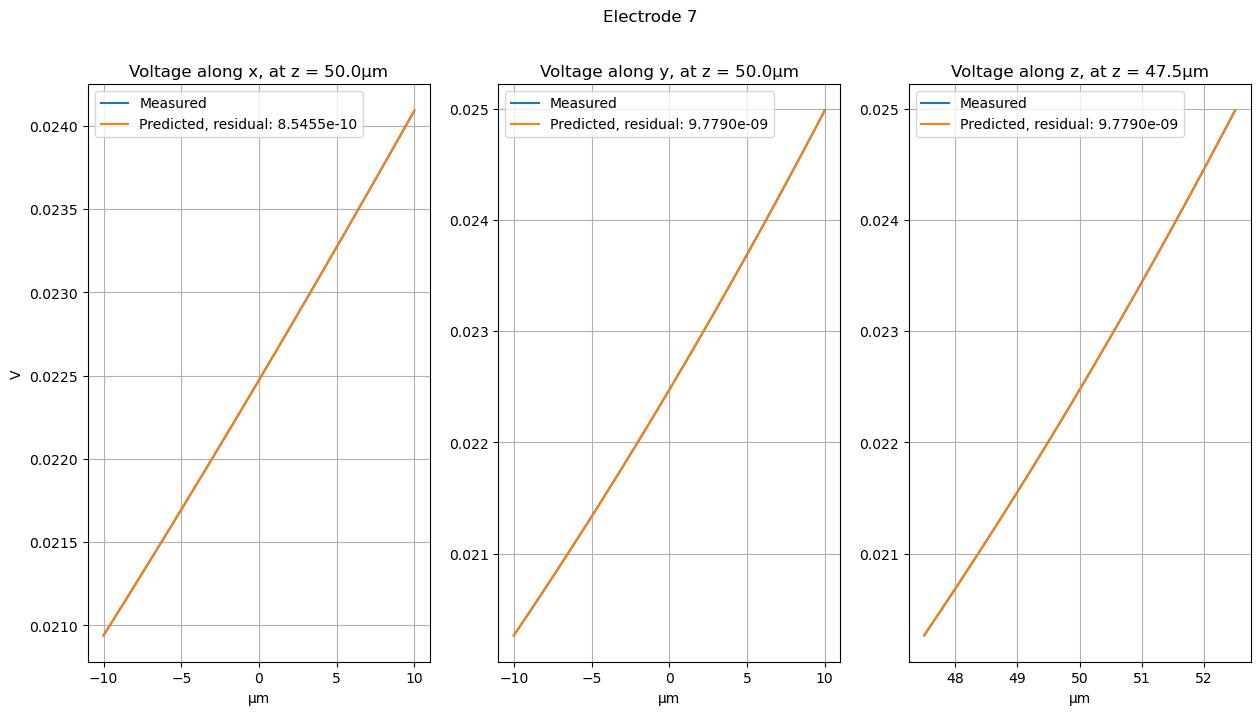

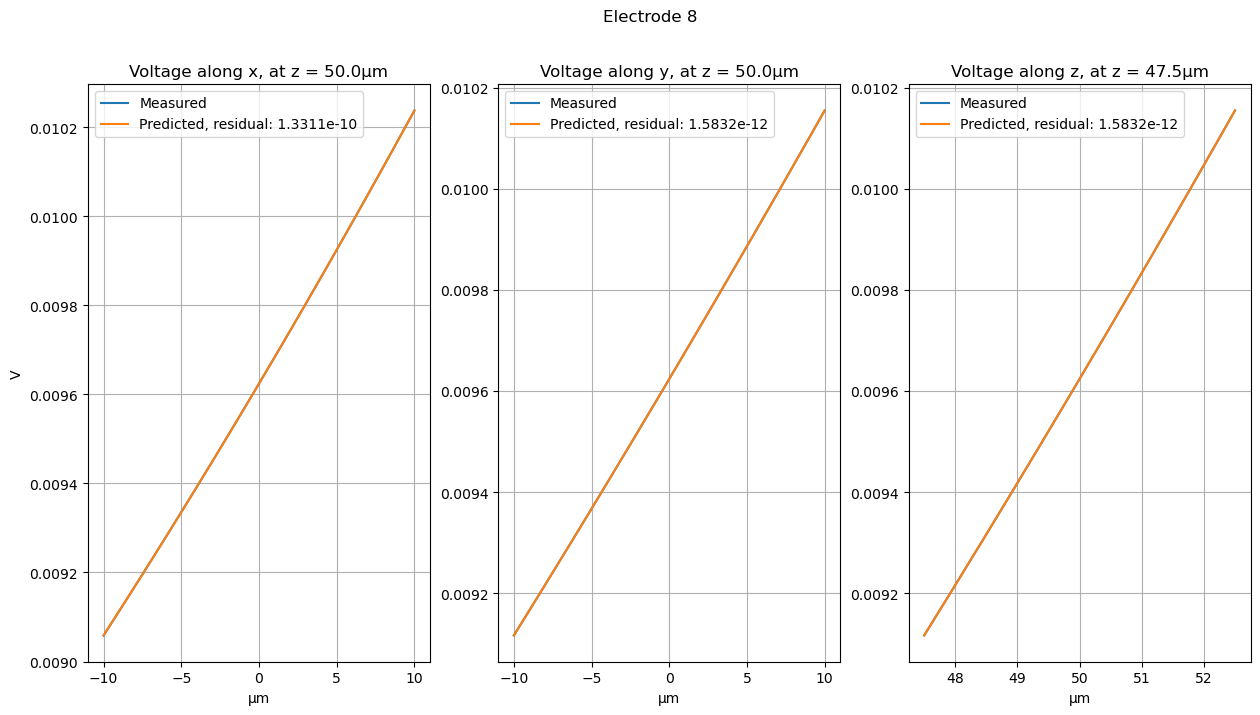

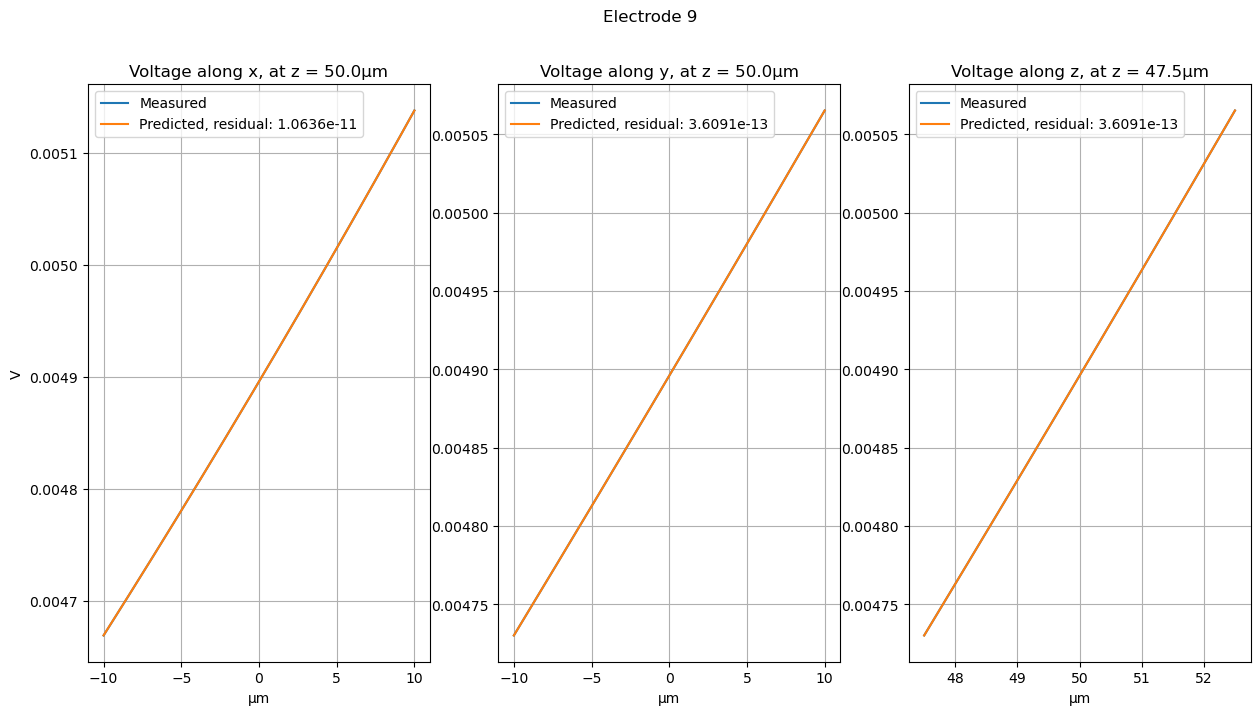

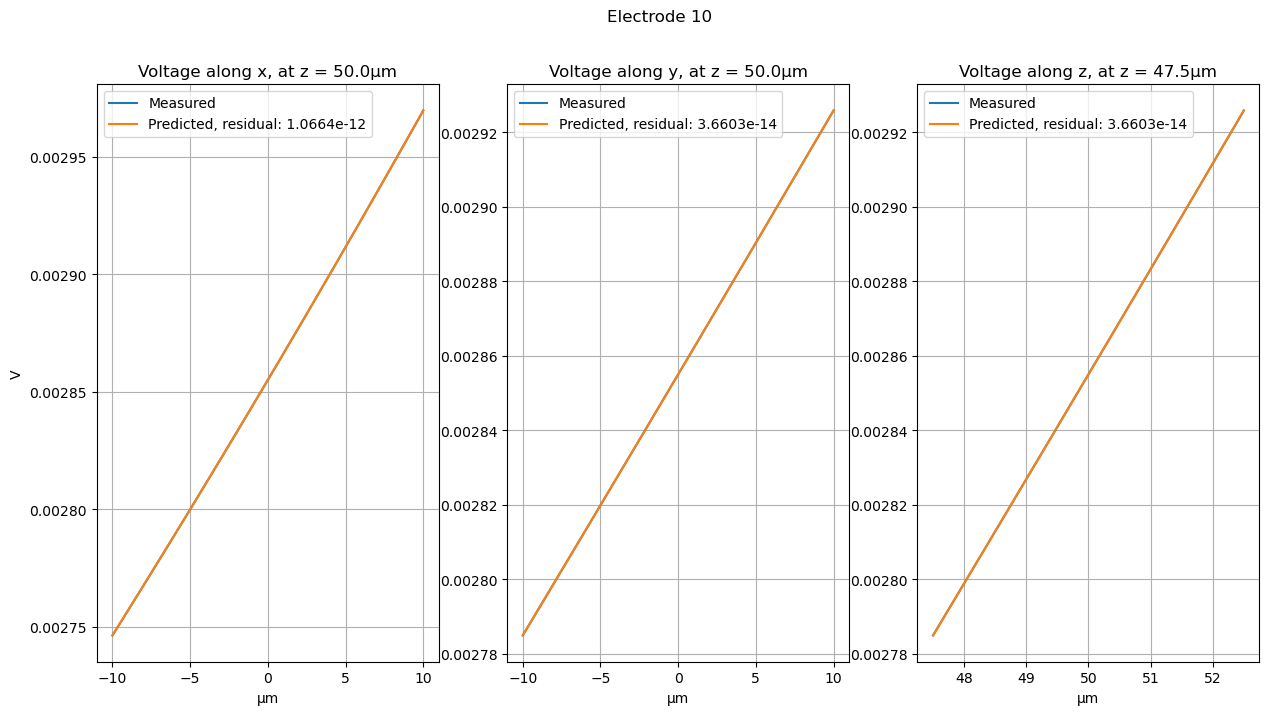

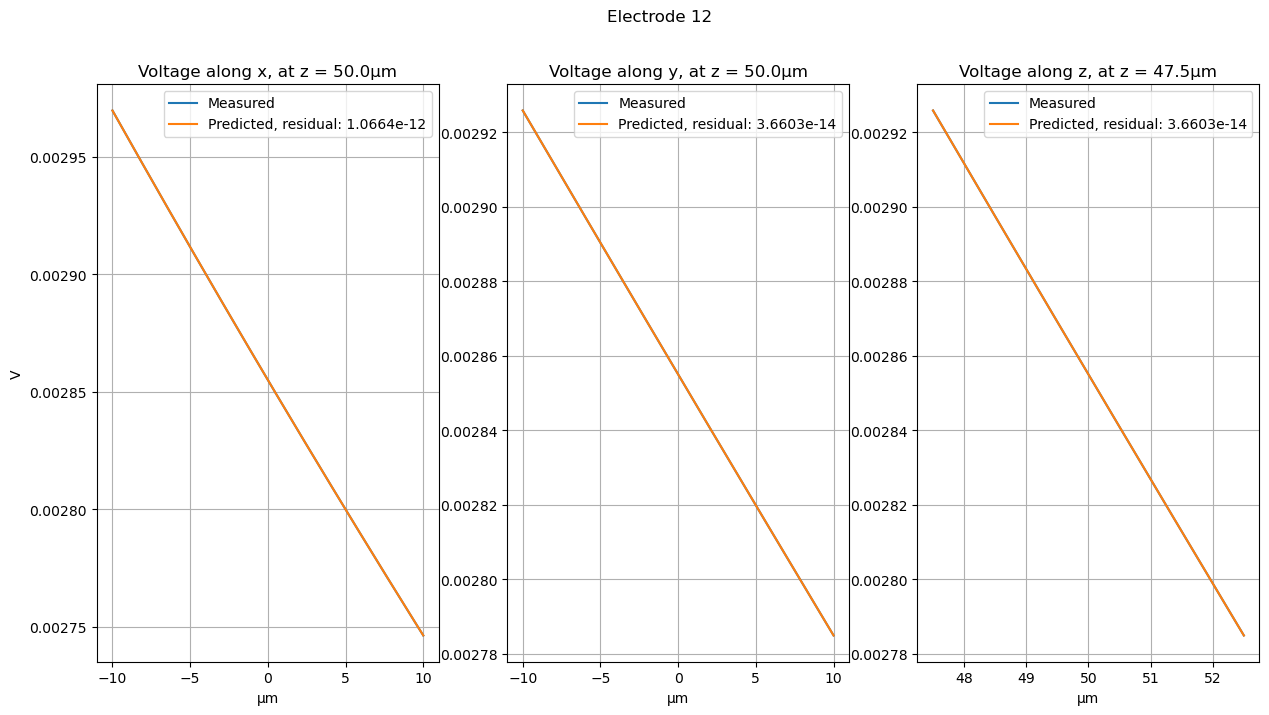

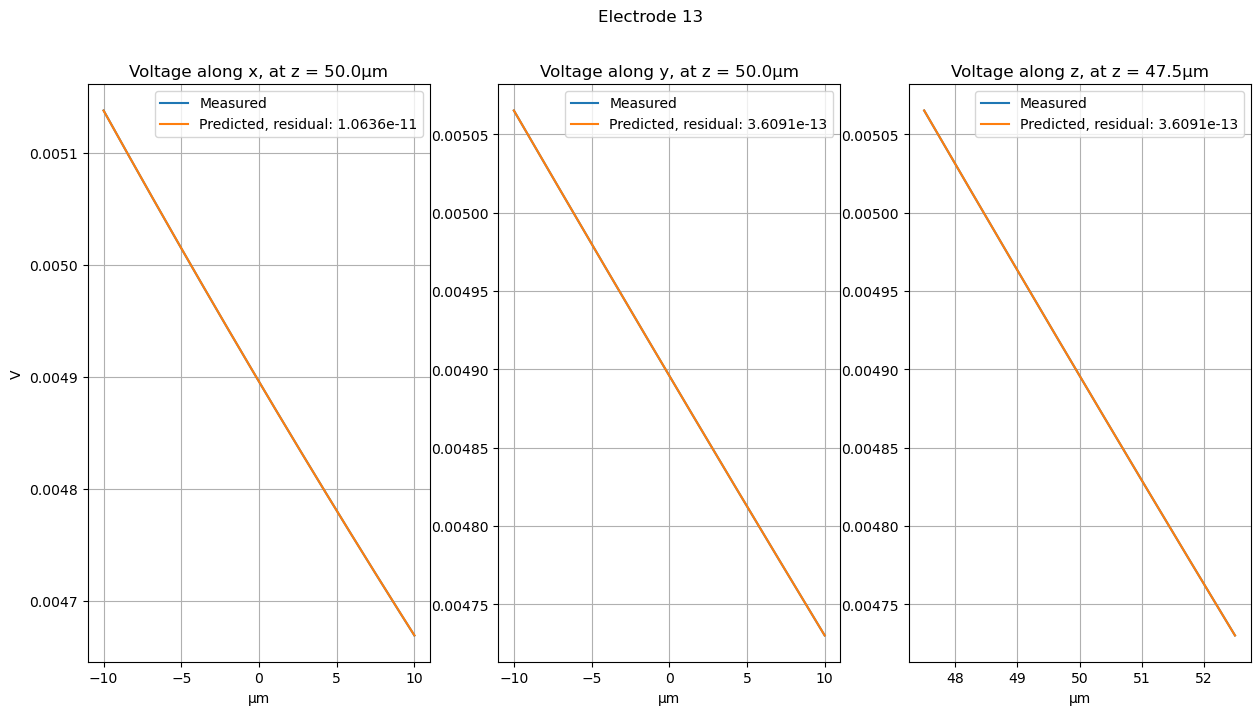

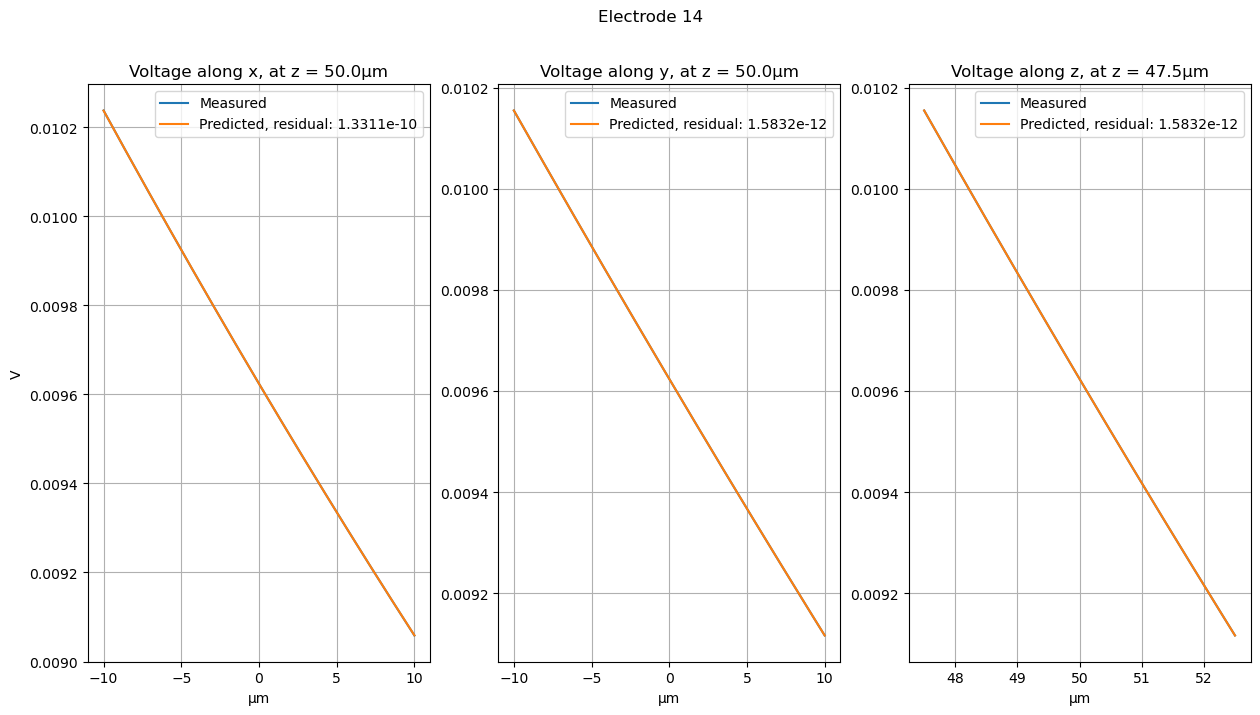

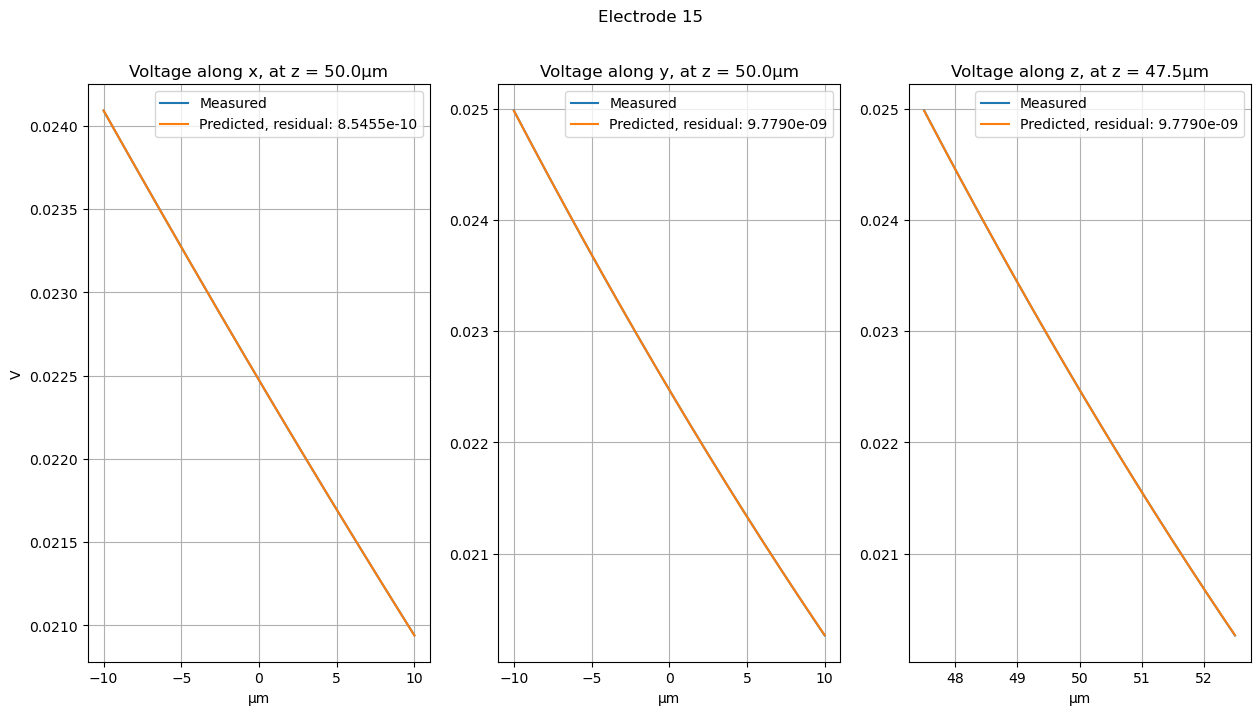

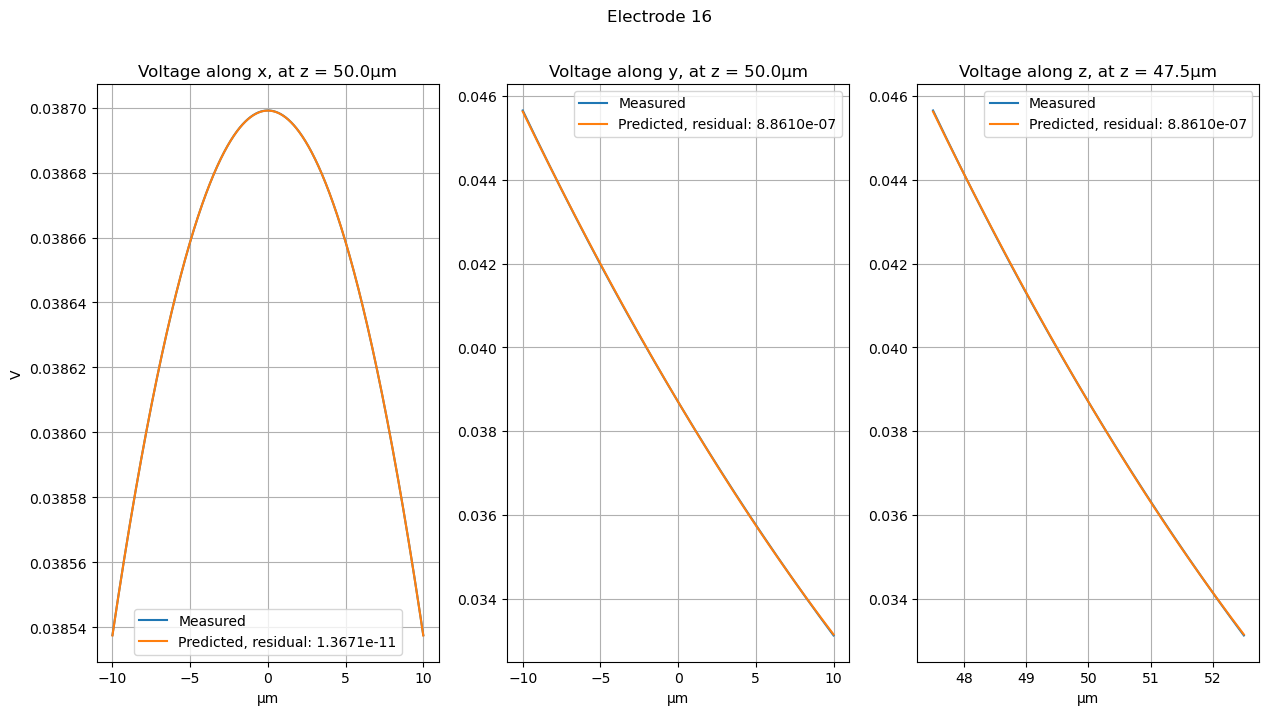

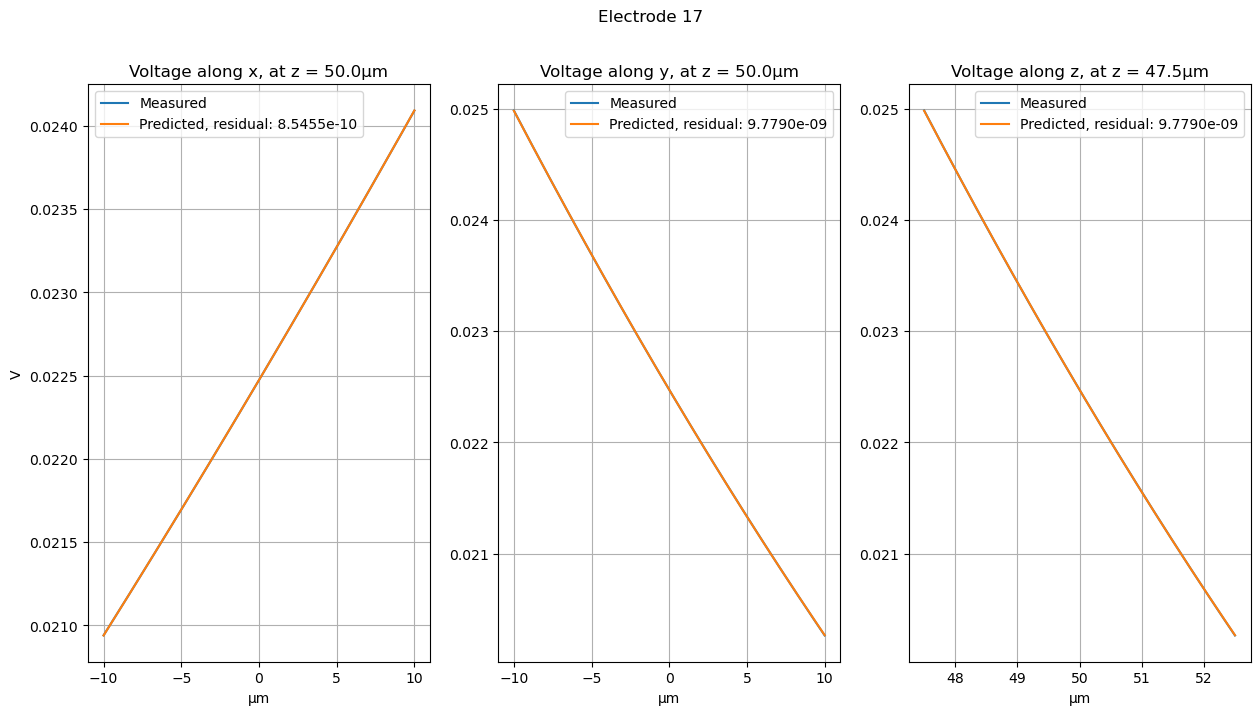

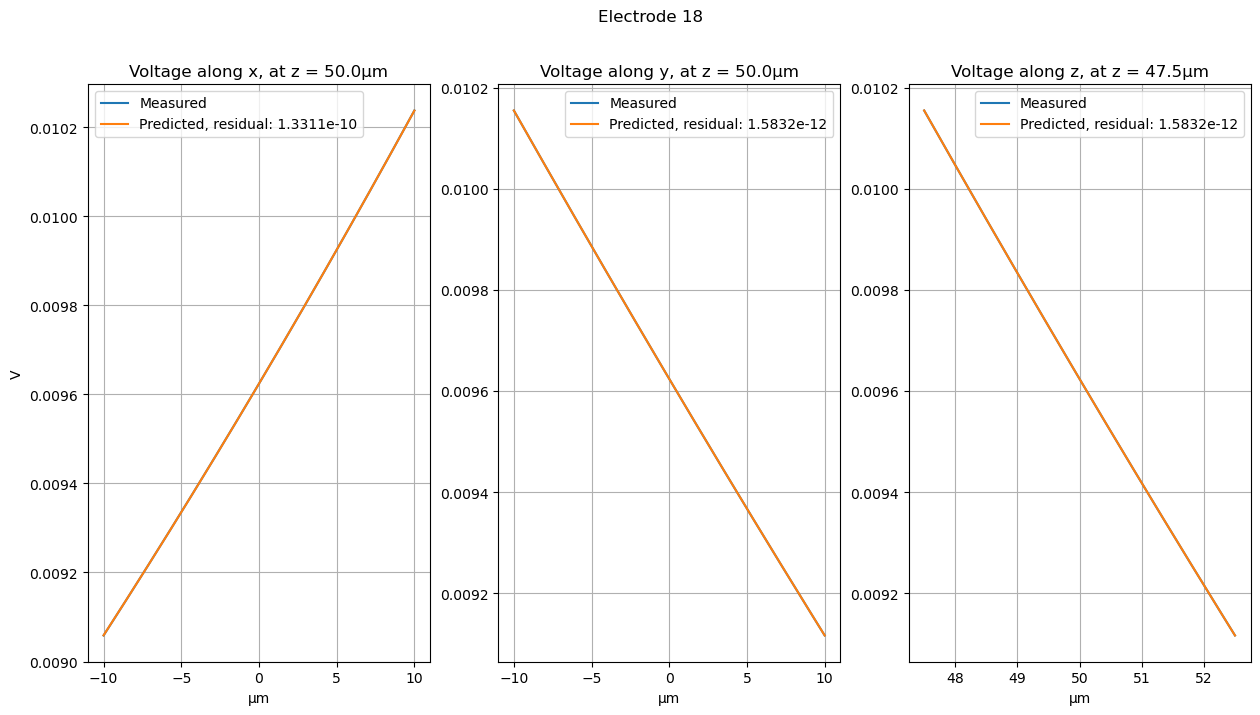

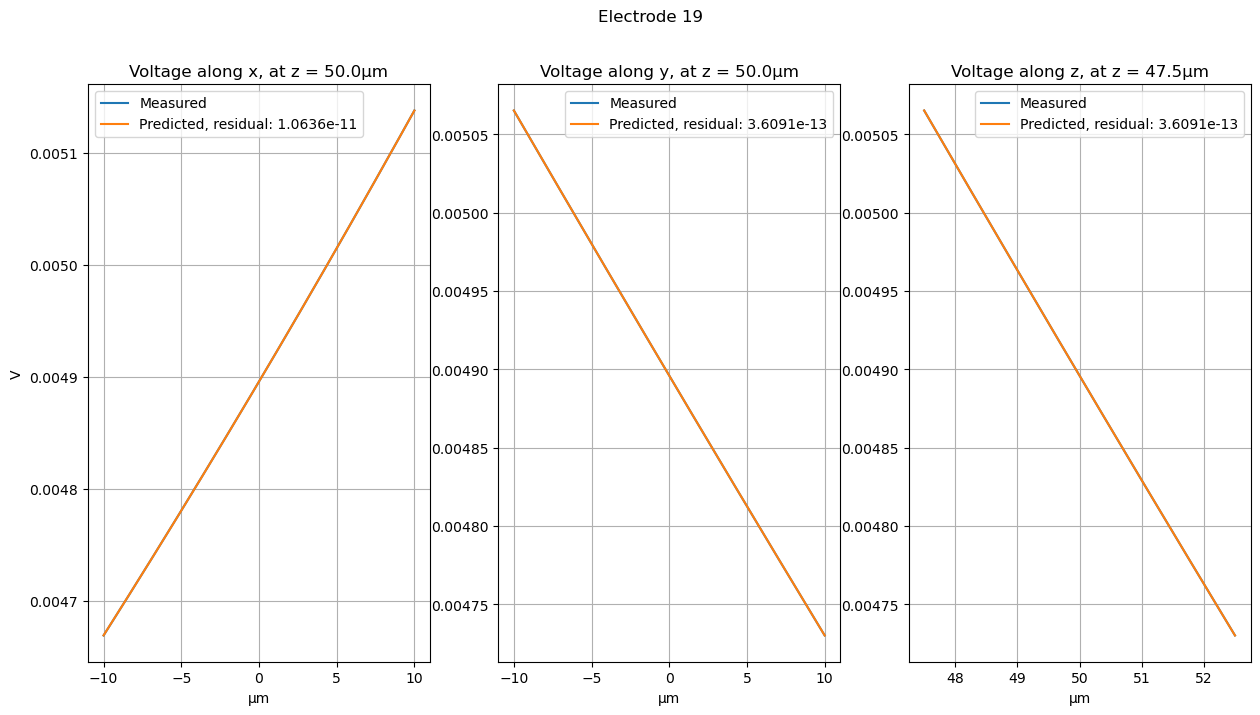

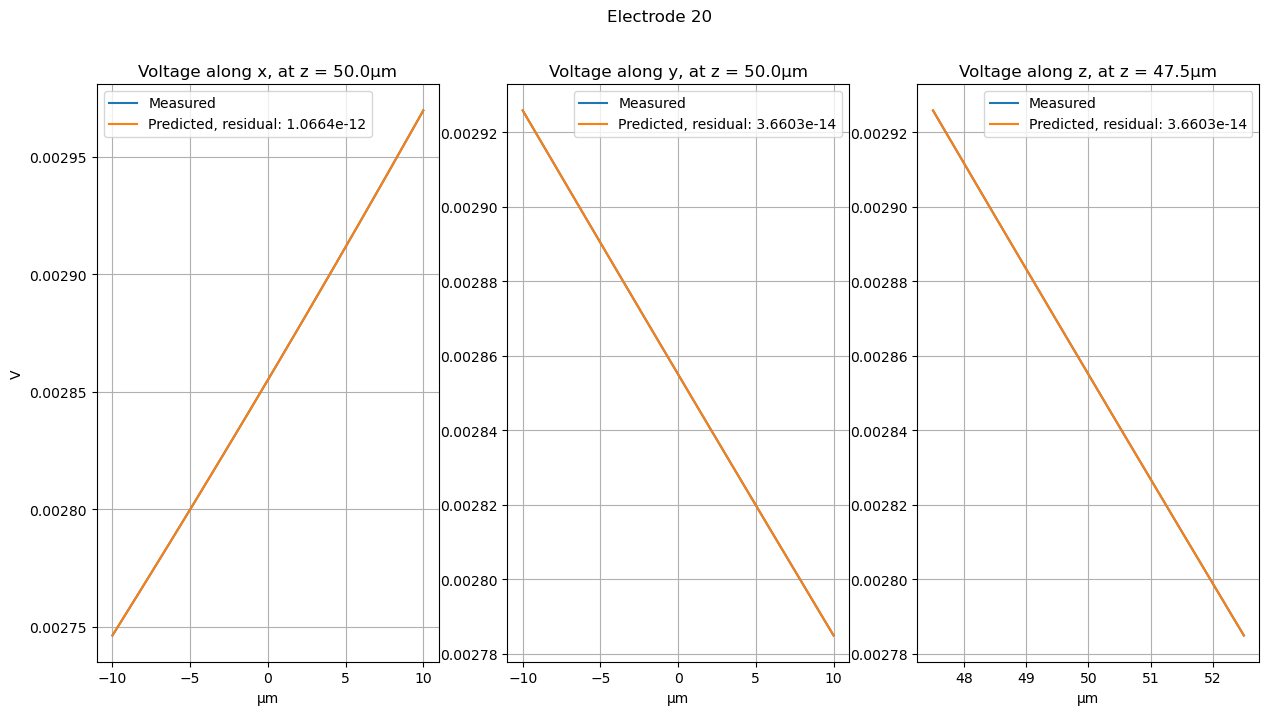

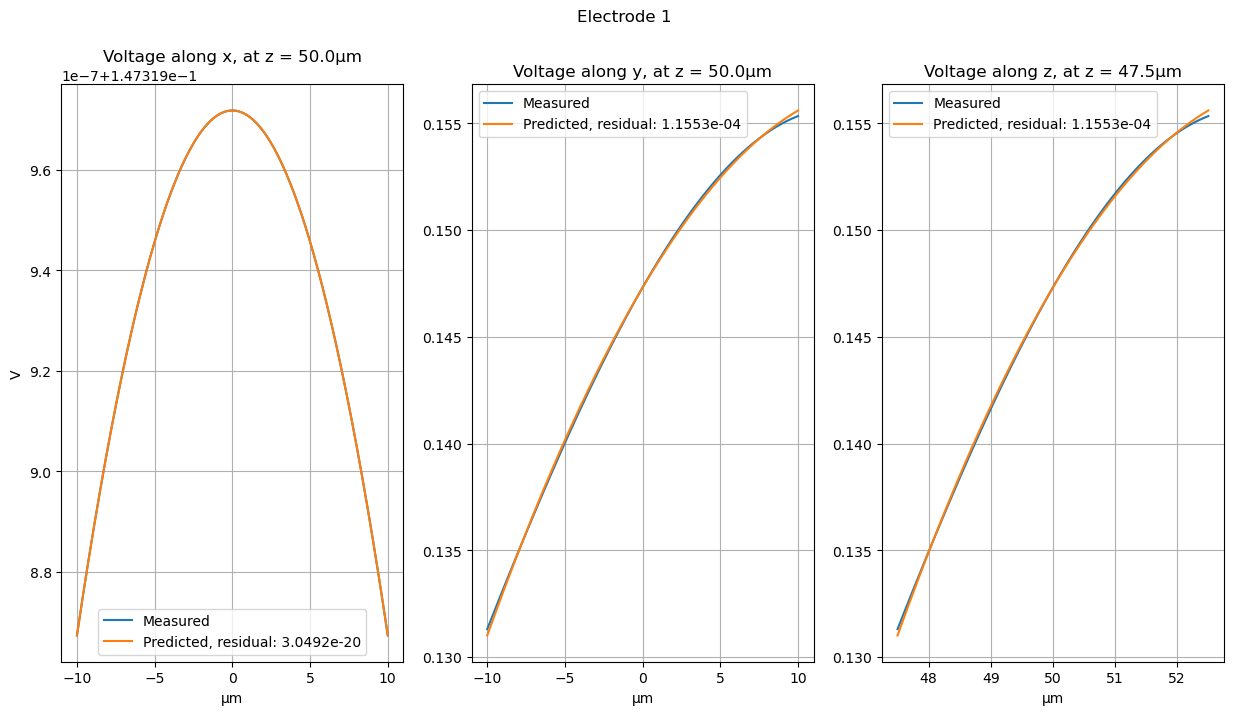

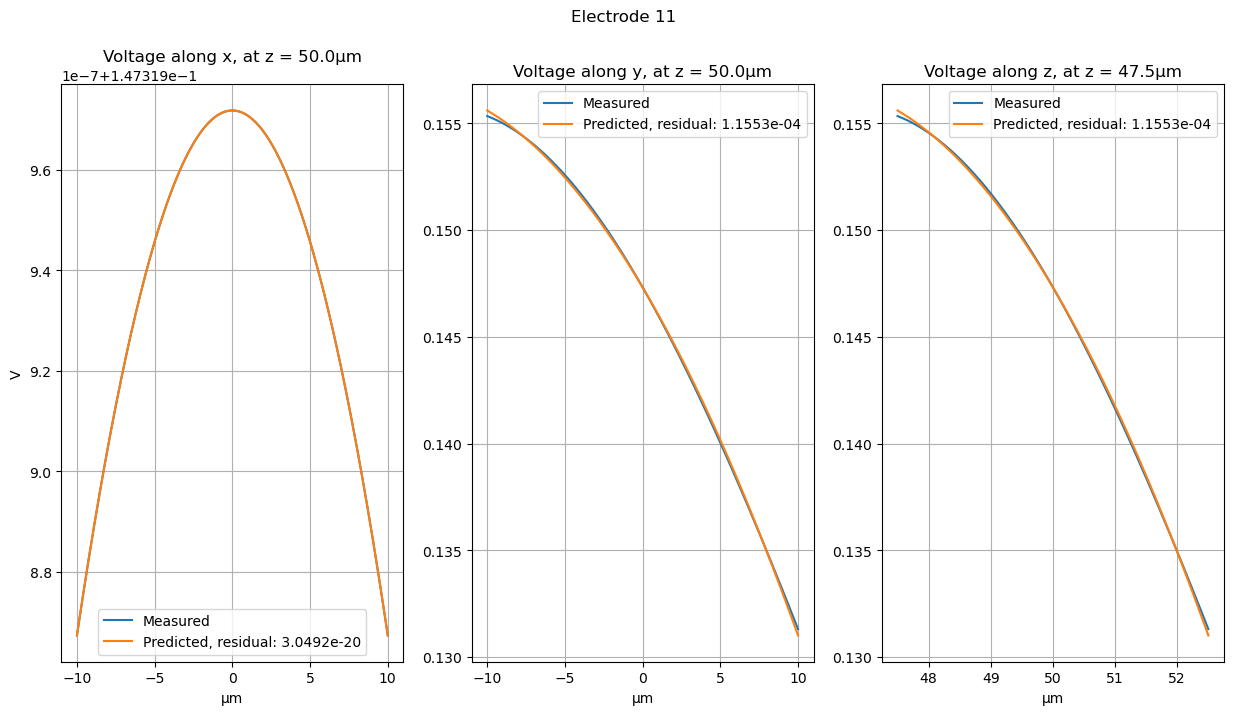

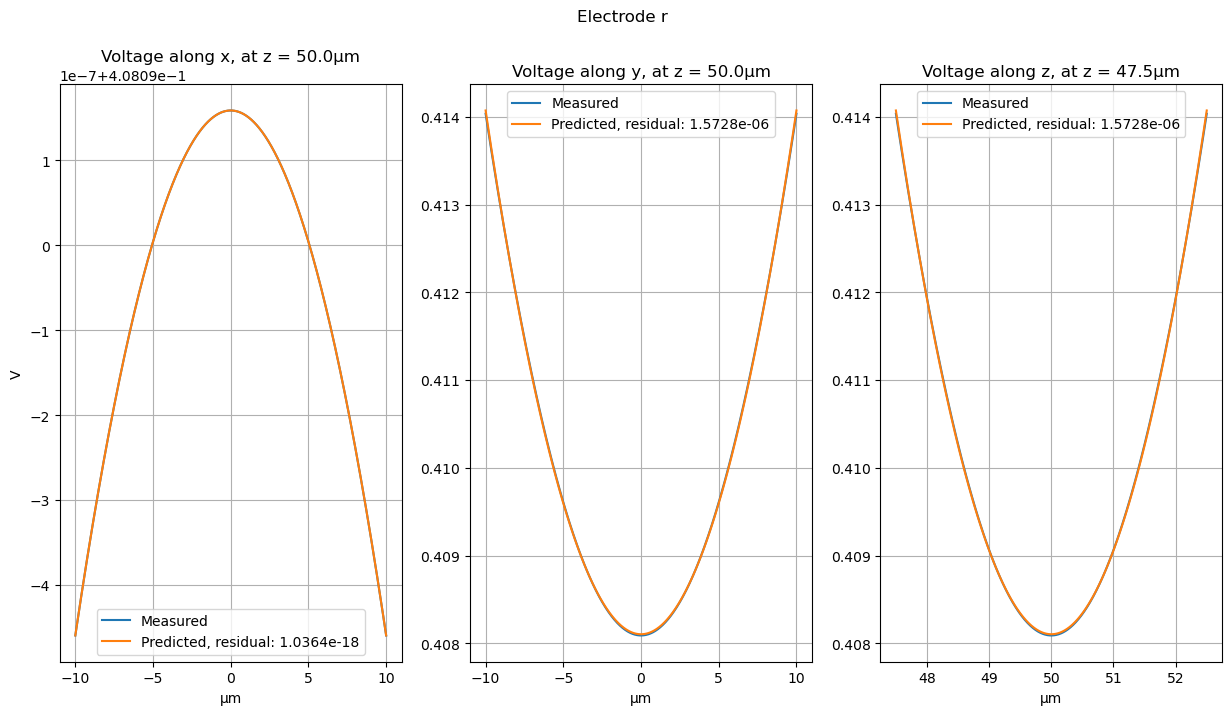

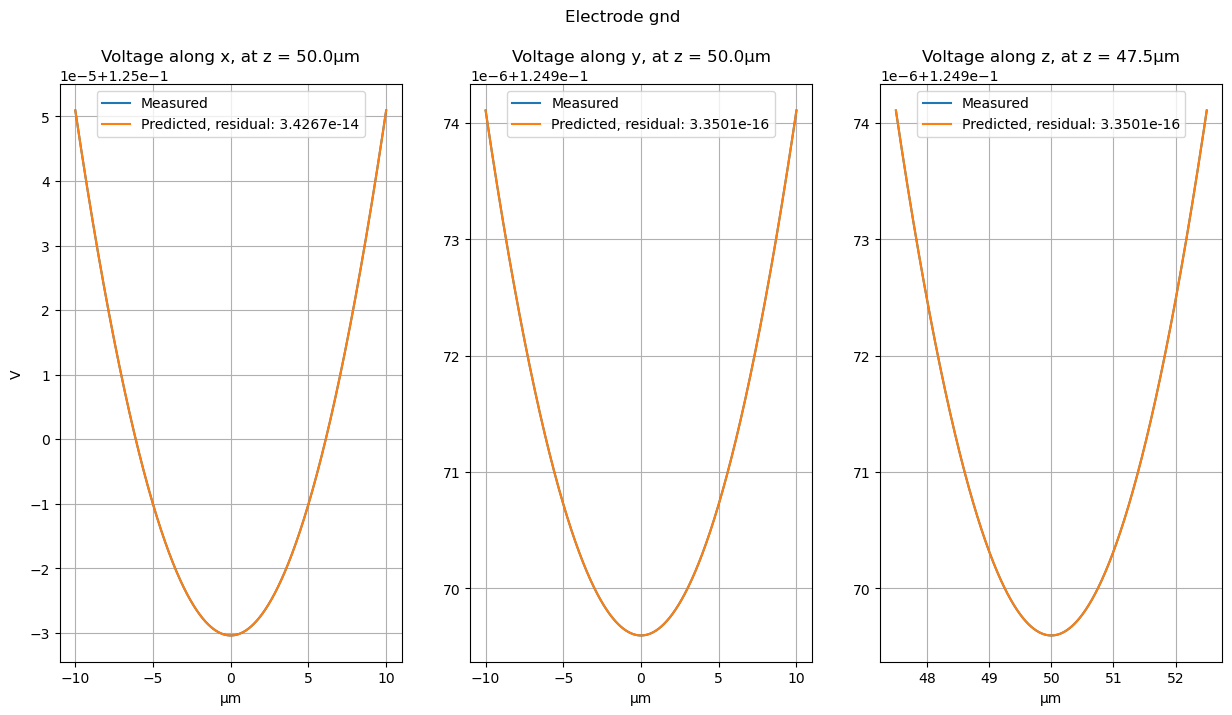

In [34]:
overall_fitted_coeffs = []
overall_residuals = []
# for electrode_num in range(3):
do_plot = True
# axes = {'x': x, 'y': y}
axes = {'x': x, 'y': y, 'z': z}
fit_order = 2
for electrode_num in range(len(s.names)):
    electrode_coeffs = []
    electrode_residuals = []
    # measured = {'x': p_x[electrode_num].flatten(), 'y': p_y[electrode_num].flatten()}
    measured = {'x': p_x[electrode_num].flatten(), 'y': p_y[electrode_num].flatten(), 'z': p_y[electrode_num].flatten()}
    num_axes = len(axes)
    if (do_plot):
        fig_width = 15
        fig, ax = plt.subplots(1, num_axes, figsize=(fig_width, 1/2*fig_width))
        ax = ax.flat
        ax[0].set_ylabel('V')
        electrode_name = s.names[electrode_num]
        fig.suptitle(f'Electrode {electrode_name}')
    for i in range(num_axes):
        ax_name = list(axes.keys())[i]
        ax_coord = list(axes.values())[i][:,i]
        z = list(axes.values())[i][:,2][0]
        # fit
        c_arr, A, residual = solve_axes_coeffs(ax_coord, measured[ax_name], order=fit_order)
        residual_str = np.format_float_scientific(residual, unique=False, precision=4)
        electrode_coeffs.append(c_arr)
        electrode_residuals.append(residual)
        # get predicted result
        predicted = np.dot(A, np.array(c_arr).T)
        if (do_plot):
            # plot numerical solution
            ax[i].set_xlabel('µm')
            ax[i].set_title(f'Voltage along {ax_name}, at z = {z}µm')
            ax[i].plot(ax_coord, measured[ax_name], label='Measured')
            # plot predicted fit
            ax[i].plot(ax_coord, predicted, label=f'Predicted, residual: {residual_str}')
            ax[i].grid()
            ax[i].legend()
    overall_fitted_coeffs.append(np.array(electrode_coeffs).flatten())
    overall_residuals.append(np.array(electrode_residuals))

# generate columns
columns = ['id']
for i in axes:
    for j in range(fit_order+1):
        columns.append('c_'+str(i)+str(j))
for i in axes:
    columns.append('residuals_' + str(i))
# generate pandas csv file
# print(overall_residuals)
savefile = np.concatenate((np.array([s.names]).T, np.array(overall_fitted_coeffs), np.array(overall_residuals)), axis=1)
df = pd.DataFrame(savefile, columns=columns)
df.to_csv(str(datetime.now()) + '_coefficients_quetzal_test_small.csv')
print(columns)


# print(a)

Find the basis voltage set

First try to get the endcap voltages

In [35]:
from scipy.optimize import linprog

In [36]:
print(overall_fitted_coeffs[0])
print(overall_fitted_coeffs[9])

[ 2.85501456e-03 -1.11705962e-05  2.98117295e-08  2.85501470e-03
  7.05061260e-06  3.90736264e-09  1.60118669e-03  2.19506702e-05
  6.25178022e-08]
[ 2.85501456e-03 -1.11705962e-05  2.98117295e-08  2.85501470e-03
 -7.05061260e-06  3.90736264e-09  4.42143173e-03 -3.44542306e-05
  6.25178022e-08]


In [37]:
print(A)
print(np.delete(A, [0, 3, 6], 0))

[[1.0000000e+00 4.7500000e+01 2.2562500e+03]
 [1.0000000e+00 4.7500500e+01 2.2562975e+03]
 [1.0000000e+00 4.7501000e+01 2.2563450e+03]
 ...
 [1.0000000e+00 5.2499000e+01 2.7561450e+03]
 [1.0000000e+00 5.2499500e+01 2.7561975e+03]
 [1.0000000e+00 5.2500000e+01 2.7562500e+03]]
[[1.0000000e+00 4.7500500e+01 2.2562975e+03]
 [1.0000000e+00 4.7501000e+01 2.2563450e+03]
 [1.0000000e+00 4.7502000e+01 2.2564400e+03]
 ...
 [1.0000000e+00 5.2499000e+01 2.7561450e+03]
 [1.0000000e+00 5.2499500e+01 2.7561975e+03]
 [1.0000000e+00 5.2500000e+01 2.7562500e+03]]


In [38]:
A = np.array(overall_fitted_coeffs).T
# delete last two columns of A, corresponding to rf and gnd electrodes
A = np.delete(A, [-1, -2], 1)
# A = np.delete(A, -1, 1)
# remove constant terms from matrix
A_noconst = np.delete(A, [0, 3, 6], 0)


# print(A)
# target [c_x0, c_x1, c_x2, c_x0, c_x1, c_x2]
# endcap from Allcock paper
b = np.array([0, 2.04e-6, 0, -1.02e-6, 0, -1.02e-6])
# c = np.ones(len(s.names)-2)
# res = linprog(c, A_ub = A, b_ub = b)
# res = linprog(c, A_eq = A, b_eq = b)
# print(np.linalg.solve(A, b))
print(np.linalg.solve(np.matmul(A_noconst.T, A_noconst), np.matmul(A_noconst.T, b)))
# print(res)

[-1.62031288e+02  8.09222909e+01 -1.82429052e+01 -3.40660044e+00
 -4.17052579e-01  3.98820875e+00  2.29077565e+01  4.75470128e+01
 -1.53547141e+02  9.73585469e+01 -5.70443961e+00  2.53958741e+00
  1.08549807e+00  1.50682323e-01 -8.34120595e-01  8.59477133e+00
 -1.11061116e+01 -1.56185199e+02  1.73533547e-02  2.71618645e-02]


Grouping electrode potentials

In [39]:

A = np.array(overall_fitted_coeffs)
# clean values below 1e-17
# A[np.abs(A)<1e-17] = 0
# remove constant terms from matrix
A = np.delete(A, [0, 3, 6], 1)
# remove rf and gnd electrodes
A = np.delete(A, [-1, -2], 0)
# print(A)

# group electrodes by adding their coefficients
# 1: 4 and 14
# 2: 8 and 18
# 3: 5, 6, 7 and 15, 16, 17
# 4: assume all others grounded

A_grouped = []
# groups = [['1'], ['11'], ['4', '14'], ['8', '18'], ['5', '6', '7'], ['15', '16', '17']]
groups = [['1'], ['11'], ['4', '8'], ['14', '18'], ['5', '6', '7'], ['15', '16', '17']]
for group in groups:
    group_coeffs = np.zeros(len(b))
    for electrode_name in group:
        # print(group_coeffs.shape)
        # print(np.array(A[s.names.index(electrode_name)]).shape)
        # group_coeffs = group_coeffs + np.array(A[np.where(s.names == electrode_name)]).flatten()
        group_coeffs += np.array(A[s.names.index(electrode_name)])
        print(group_coeffs)
    # for item in range(len(group_coeffs)):
    #     if(np.abs(group_coeffs[item]) < 1e-17):
    #         group_coeffs[item] = 0
    # print(group_coeffs)
    A_grouped.append(group_coeffs)
# target [c_x0, c_x1, c_x2, c_x0, c_x1, c_x2]
# endcap from Allcock paper
# b = np.array([0, -1.02e-6, 0, -1.02e-6, 0, 2.04e-6])
b = np.array([0, 2.04e-6, 0, -1.02e-6, 0, -1.02e-6])
A_grouped = np.array(A_grouped)
soln1 = np.linalg.solve(np.matmul(A_grouped, A_grouped.T), np.matmul(A_grouped, b))
# soln2 = np.linalg.solve(A_grouped, b)
soln2 = np.linalg.lstsq(A_grouped, b, rcond=None)
print(soln1)
print(soln2)

# print(A_grouped)

[-1.07269609e-19 -1.04461162e-09  1.22999914e-03 -4.00772485e-05
  6.90435941e-02 -6.41235976e-04]
[-1.02115653e-19 -1.04461162e-09 -1.22999914e-03 -4.00772485e-05
  5.92036010e-02 -6.41235976e-04]
[-5.89394381e-05  2.40882760e-07  5.19348141e-05  1.18357345e-07
  1.83675047e-05  1.89371752e-06]
[-6.77626358e-20  4.81765520e-07  1.03869628e-04  2.36714689e-07
  3.67350093e-05  3.78743503e-06]
[-5.89394381e-05  2.40882760e-07 -5.19348141e-05  1.18357345e-07
 -3.97111008e-04  1.89371752e-06]
[ 0.00000000e+00  4.81765520e-07 -1.03869628e-04  2.36714689e-07
 -7.94222016e-04  3.78743503e-06]
[-1.57687962e-04  4.28331945e-07  2.35825073e-04  1.51620039e-06
 -1.48262033e-03  2.42592062e-05]
[-1.57687962e-04 -1.18764155e-06  8.60094113e-04  8.41916585e-06
 -1.00302889e-02  1.34706654e-04]
[ 2.43945489e-19 -7.59309600e-07  1.09591919e-03  9.93536624e-06
 -1.15129092e-02  1.58965860e-04]
[-1.57687962e-04  4.28331945e-07 -2.35825073e-04  1.51620039e-06
 -3.36922092e-03  2.42592062e-05]
[-1.576879

In [41]:
print(A_grouped)

[[-1.07269609e-19 -1.04461162e-09  1.22999914e-03 -4.00772485e-05
   6.90435941e-02 -6.41235976e-04]
 [-1.02115653e-19 -1.04461162e-09 -1.22999914e-03 -4.00772485e-05
   5.92036010e-02 -6.41235976e-04]
 [-6.77626358e-20  4.81765520e-07  1.03869628e-04  2.36714689e-07
   3.67350093e-05  3.78743503e-06]
 [ 0.00000000e+00  4.81765520e-07 -1.03869628e-04  2.36714689e-07
  -7.94222016e-04  3.78743503e-06]
 [ 2.43945489e-19 -7.59309600e-07  1.09591919e-03  9.93536624e-06
  -1.15129092e-02  1.58965860e-04]
 [ 1.62630326e-19 -7.59309600e-07 -1.09591919e-03  9.93536624e-06
  -2.02802627e-02  1.58965860e-04]]


In [45]:
# print(np.array([soln2]))
# print(np.allclose(np.matmul(np.matmul(A_grouped, A_grouped.T), np.array([soln]).T), np.matmul(A_grouped, b)))
temp1 = np.matmul(A_grouped, soln2[0])
print(temp1)
print(np.allclose(temp1, b))
print(b - temp1)

# print(np.matmul(np.matmul(A_grouped, A_grouped.T), np.array([soln]).T))

[ 8.06029494e-07  1.38629257e-06 -6.76601867e-08 -1.86587621e-08
 -4.72409392e-07  4.46002706e-08]
False
[-8.06029494e-07  6.53707428e-07  6.76601867e-08 -1.00134124e-06
  4.72409392e-07 -1.06460027e-06]


In [1]:
electrode_voltages = np.zeros(len(s.names))
for i in range(len(groups)):
    group_coeffs = np.zeros(len(b))
    for electrode_name in groups[i]:
        electrode_voltages[s.names.index(electrode_name)] = soln[i]
print(electrode_voltages)

x = single_axis('x', (-length/2,length/2), res)
y = single_axis('y', (-length/2,length/2), res)
z = single_axis('z', (-length/2,length/2), res)

with s.with_voltages(electrode_voltages):
    vx = s.electrical_potential(x).T
    vy = s.electrical_potential(y).T
    vz = s.electrical_potential(z).T
    # print(vx)
    plt.plot(x[:, 0], vx[0])
    plt.plot(x[:, 0], 2.04e-6*x[:, 0]**2)
    plt.figure()
    plt.plot(y[:, 1], vy[0])
    plt.figure()
    plt.plot(z[:, 2], vz[0])

NameError: name 'np' is not defined

Grouping experiment 2

In [275]:

A = np.array(overall_fitted_coeffs)
# remove constant terms from matrix
A = np.delete(A, [0, 3, 6], 1)
# remove rf and gnd electrodes
A = np.delete(A, [-1, -2], 0)
# print(A)

# group electrodes by adding their coefficients
# 1: 4 and 14
# 2: 8 and 18
# 3: 5, 6, 7 and 15, 16, 17
# 4: assume all others grounded

A_grouped = []
groups = [['1', '11'], ['4', '8', '14', '18'], ['5', '6', '7', '15', '16', '17']]
for group in groups:
    group_coeffs = np.zeros(len(b))
    for electrode_name in group:
        # print(group_coeffs.shape)
        # print(np.array(A[s.names.index(electrode_name)]).shape)
        # group_coeffs = group_coeffs + np.array(A[np.where(s.names == electrode_name)]).flatten()
        group_coeffs += np.array(A[s.names.index(electrode_name)])
    # normalizing small components to zero
    # for item in range(len(group_coeffs)):
    #     if(np.abs(group_coeffs[item]) < 1e-17):
    #         group_coeffs[item] = 0
    print(group_coeffs)
    A_grouped.append(group_coeffs)
    # print(group_coeffs)
# target [c_x1, c_x2, c_x0, c_x1, c_x2]
# endcap from Allcock paper
b = np.array([0, 2.04e-6, 0, -1.02e-6, 0, -1.02e-6])
A_grouped = np.array(A_grouped)
print(np.linalg.solve(np.matmul(A_grouped, A_grouped.T), np.matmul(A_grouped, b)))
# print(A_grouped)

[-1.45023518e-18 -2.08922576e-09 -1.30104261e-18 -8.01459921e-05
  8.01459921e-03 -8.01459921e-05]
[ 0.00000000e+00  9.63534787e-07  8.80914265e-20  4.73426175e-07
 -4.73426175e-05  4.73426175e-07]
[-4.87890978e-19 -1.51862462e-06 -2.16840434e-19  1.98712767e-05
 -1.98712767e-03  1.98712767e-05]
[-0.1021258   1.41465244 -0.44561361]


In [165]:
s.names

['2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '1',
 '11',
 'r',
 'gnd']

In [34]:
print(list({'1': 1}.keys()))
for i in {'1': 1}:
    print (type(i))
# {list(axes.keys())[i]}

['1']
<class 'str'>


In [273]:
z = 50 # height of ion above metal in microns
dz = 2
x_max = 750
y_max = 750
x_b = (-x_max, x_max)
y_b = (-y_max, y_max)
z_b = (z - dz, z + dz)

# gr = (200, 200, 20)
gr = (2250, 2250)
xy, tsx, tsy = make_xy_grid_flat(x_b, y_b, z, grid_res=gr)
# xyz, tsx, tsy, tsz = make_xyz_grid_flat(x_b, y_b, z_b, grid_res=gr)
xyz = np.array(xy)
# print(xyz[:, 0])